In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Value:
    def __init__(self, data, _children=(), _op='', label =''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            #self._backward()
            #other._backward()
        out._backward = backward
        return out
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __neg__(self):
        return self * -1
    
    def __rsub__(self, other):
        return self.__sub__(other)
    
    def __sub__(self, other):
        return self + (-other)
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            #self._backward()
            #other._backward()
        out._backward = backward
        return out
    
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def backward():
            self.grad += (other * self.data**(other-1)) * out.grad
            #self._backward()
        out._backward = backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def backward():
            self.grad += math.exp(self.data) * out.grad
            #self._backward()
        out._backward = backward
        return out
    
    def tanh(self):
        n = self.data
        tanh = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(tanh, (self,), 'tanh')

        def backward():
            self.grad += (1 - tanh**2) * out.grad
            #self._backward()
        out._backward = backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

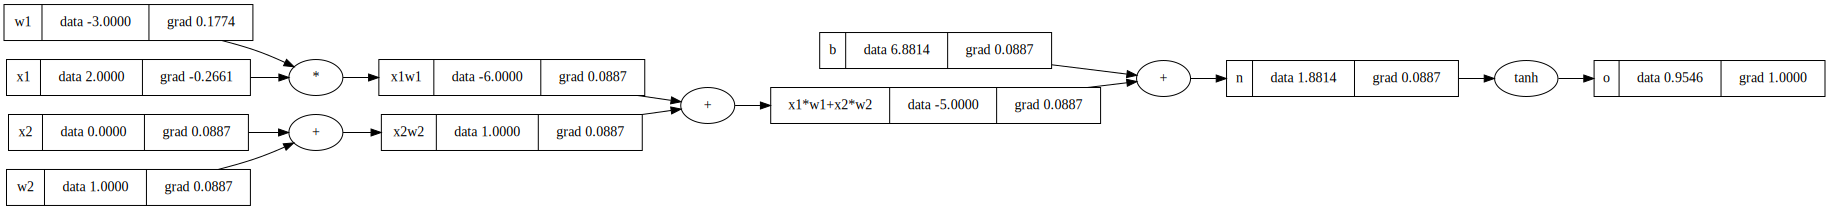

In [5]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137358702, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2+w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

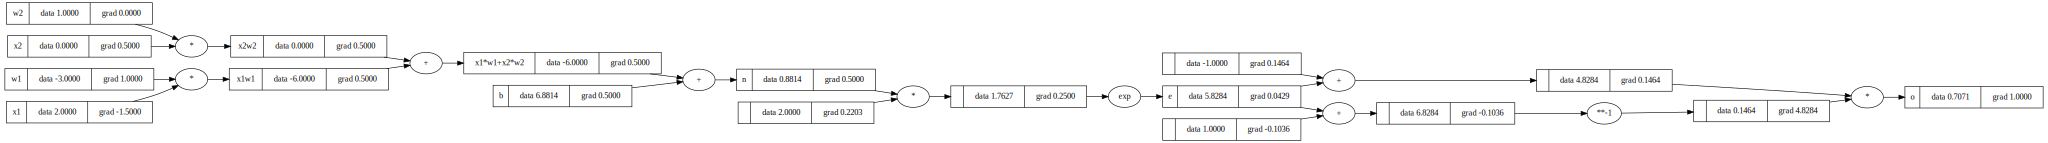

In [6]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137358702, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()
draw_dot(o)

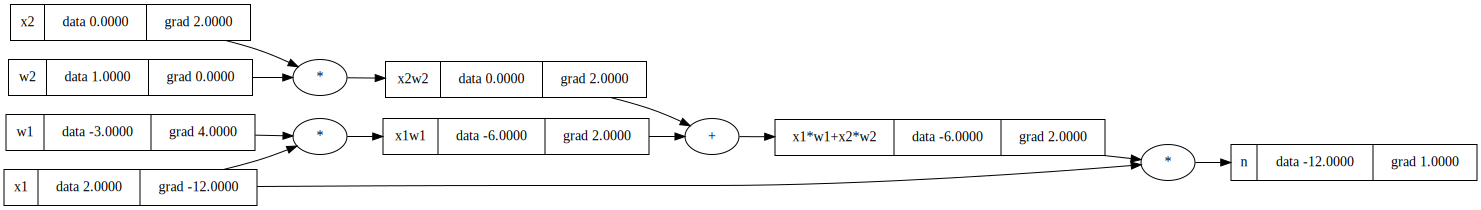

In [7]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137358702, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 * x1; n.label = 'n'

n.backward()
draw_dot(n)

In [8]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137358702]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

0.7071066904050358
---
-1.5000003851533106
0.5000001283844369
1.0000002567688737
0.0


In [9]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        #print(list(zip(self.w, x)))
        act = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b
        return act.tanh()
    
    def __repr__(self):
        return f"Neuron({self.w})"
    
    def parameters(self):
        return self.w + [self.b]
        
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        #print(self.neurons)
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def __repr__(self):
        return f"Layer({self.neurons})"
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    def __init__(self, nin, nout):
        sz = [nin] + nout
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def __repr__(self):
        for layer in self.layers:
            print(layer)
        return f"MLP({self.layers})"
    
    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params

In [10]:
x = [2.0, 3.0, -1.0]

n = MLP(3, [4,4,1])
len(n.parameters())


41

In [11]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [12]:
for k in range(10):
    ypred = [n(x) for x in xs]
    loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))
    print(loss)
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data -= 0.1 * p.grad


Value(data=8.03268629523276)
Value(data=7.703357649433878)
Value(data=6.766359669405691)
Value(data=3.0091985890312563)
Value(data=1.8264066296641388)
Value(data=1.8000064284575443)
Value(data=0.09619265648200401)
Value(data=0.06203916033510453)
Value(data=0.04690701520076478)
Value(data=0.03816805471575642)


In [13]:
ypred

[Value(data=0.9516595059516755),
 Value(data=-0.839252367352409),
 Value(data=-0.9124382531378478),
 Value(data=0.9517880674981406)]